In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import sys
import os
import numpy as np
import functools

from clock.vis import visualize_latent, visualize_predictions, visualize_reconstruction, print_model_parameters, show_data, map_inputs
from clock.utils import eval_model, load_model_and_dataset, eval_model

from datasets.clock import ClockConfig, get_dataloaders, ClockDatasetConfig
from models.decoders import ImplicitNeuralDecoder, ResNetDecoder3, ResNetDecoder4
from models.autoencoders import MLPResnetAutoencoder, ConvINRAutoencoder
from models.encoders import ConvMLPEncoder

device = "cuda" if torch.cuda.is_available() else "cpu"

model_dir="saved_models/ConvMLPEncoder/-1-i64-d19-"

load_model_checkpoint = functools.partial(
  load_model_and_dataset, 
  model_class=ConvMLPEncoder, 
  model_dir=model_dir,
)

dataloader, dataset, _, _ = get_dataloaders(
  data_config = ClockConfig(),
  dataset_config=ClockDatasetConfig(
    img_size=64
  ),
)

cp = load_model_checkpoint(checkpoint=None)

# Encoders

In [3]:
eval_model(cp.model, cp.type, cp.latent_dim, nn.SmoothL1Loss(), [i for i in cp.val_dataloader], device=device)

0.0006632734766753856

In [4]:
cp.model



ConvMLPEncoder(
  (conv): Sequential(
    (0): ConvResidualEncoderBlock2(
      (downsample1): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.1)
      )
      (downsample2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slop

In [5]:
from tqdm.notebook import tqdm

def extract_features(x):
  model = cp.model
  x = x.to(device)
  x = model.conv(x)
  x = model.fc(x)
  return x

cp.dataloader.dataset.config.data_size = 2**18

feature_batches = [[out[4], out[2]] for out in tqdm(map_inputs(cp, extract_features, limit=None), total=len(cp.dataloader.dataset))]

  0%|          | 0/262144 [00:00<?, ?it/s]

(array([24.,  8.,  2.,  0.,  1.,  0.,  1.,  1.,  6., 21.]),
 array([-0.93420845, -0.74399626, -0.55378401, -0.36357182, -0.17335957,
         0.01685268,  0.20706481,  0.39727706,  0.58748931,  0.77770156,
         0.96791381]),
 <BarContainer object of 10 artists>)

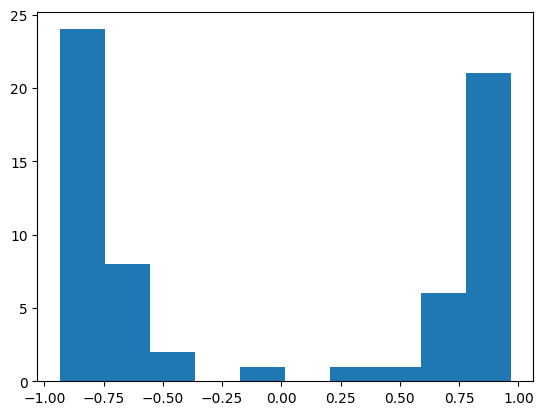

In [21]:
plt.hist(feature_batches[0][0].cpu().numpy())

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from models.autoencoders import MLPAutoencoder
from models.decoders import ActivationType
from models.other import MLP
from tqdm.notebook import tqdm


class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, data):
    self.batches = data

  def __len__(self):
    return len(self.batches)

  def __getitem__(self, idx):
    return self.batches[idx]

dataset = CustomDataset(feature_batches)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

model = MLPAutoencoder(
  encoder_dims=[64, 64],
  decoder_dims=[64, 64],
  decoder_activation = ActivationType.tanh,
)

model = model.to(device)

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

model.train()

n_epochs = 30

accum_loss = 0
t = tqdm(total=len(dataloader)*n_epochs)
for i in range(n_epochs):
  for j, (batch, label) in enumerate(dataloader):

    step = i * len(dataloader) + j
    optimizer.zero_grad()
    batch = batch.to(device)
    latent = model(batch)
    loss = criterion(latent, batch)
    loss.backward()
    optimizer.step()
    
    t.update(1)
    accum_loss += loss.item()
    if step % 10 == 0:
      avg_loss = accum_loss / 10
      t.set_description(f"Epoch {i}/{n_epochs}. Loss {avg_loss:.4f}")
      accum_loss = 0

t.close()

  0%|          | 0/61440 [00:00<?, ?it/s]

(262144, 2) (262144,)


Text(0.5, 1.0, 'Latent space')

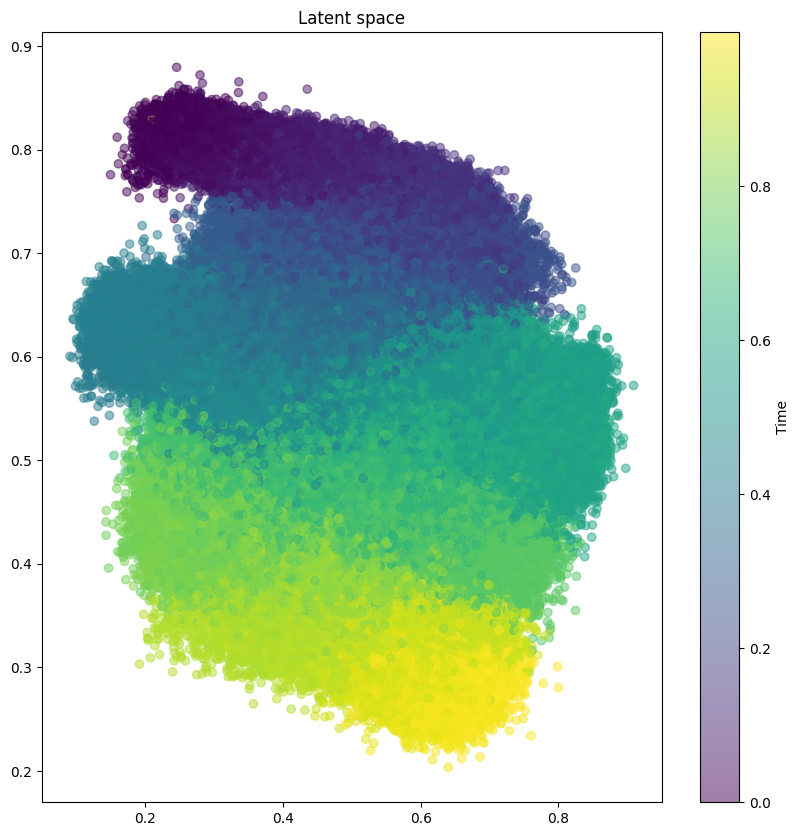

In [15]:
import matplotlib.pyplot as plt

probe_latents=[]
labels = []

for batch, label in dataloader:
  batch = batch.to(device)
  latent = model.encoder(batch)
  probe_latents.append(latent.cpu().detach().numpy())
  labels.append(label.cpu().numpy())

probe_latents = np.array(probe_latents).reshape(-1, 2)
labels = np.array(labels).reshape(-1)

print(probe_latents.shape, labels.shape)

plt.figure(figsize=(10, 10))
plt.scatter(probe_latents[:, 0], probe_latents[:, 1], alpha=0.5, c=labels, cmap='viridis')
plt.colorbar(label="Time")
plt.title("Latent space") 


# Decoders

In [ ]:
inputs = next(iter(cp.dataloader))
print(inputs[0].shape)
# model = cp.model

original = inputs[0]
imgs = inputs[2].to(device)

layer_outs = []

out = model.fc(imgs)
# get residual
out = model.decoder_conv[0](out)
layer_outs.append(out)
print("conv1", out.shape, np.prod(out.shape[1:]))
out = model.decoder_conv[1](out)
layer_outs.append(out)
print("conv2", out.shape, np.prod(out.shape[1:]))
out = model.decoder_conv[2](out)
layer_outs.append(out)
print("conv3", out.shape, np.prod(out.shape[1:]))
out = model.decoder_conv[3](out)
layer_outs.append(out)
print("conv4", out.shape, np.prod(out.shape[1:]))
out = model.decoder_conv[4](out)
layer_outs.append(out)
print("conv5", out.shape, np.prod(out.shape[1:]))


NameError: name 'inputs' is not defined

In [6]:
print_model_parameters(model)


Layer                                       Param Count
------------------------------------------------------------
------------------------------------------------------------
Total Trainable Parameters                   14,231,025


: 

0 torch.Size([64, 512, 2, 2])
1 torch.Size([64, 32, 8, 8])
2 torch.Size([64, 8, 16, 16])
3 torch.Size([64, 2, 32, 32])
4 torch.Size([64, 2, 64, 64])


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 1024])

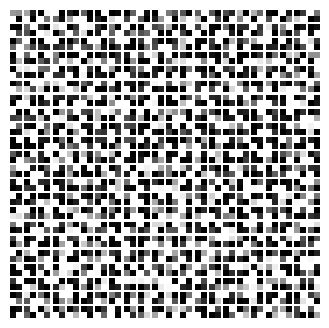

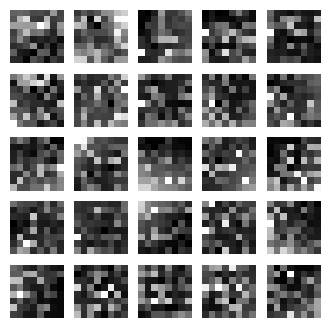

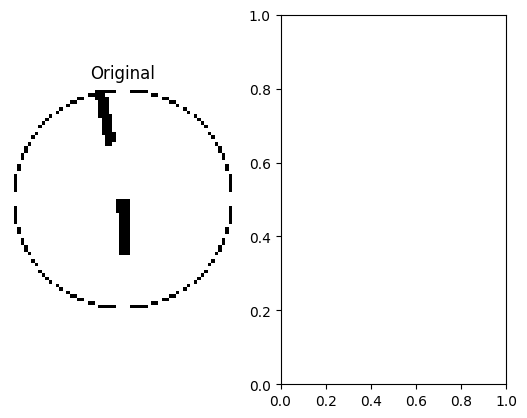

In [21]:
import matplotlib.pyplot as plt
import numpy as np

idx = np.random.randint(0, len(layer_outs)-1)
figsize=(4,4)

for i, out in enumerate(layer_outs):
  print(i, out.shape)
  if (out.shape[1] < 16):
    continue
  
  sqrt_n_channels = int(np.sqrt(out.shape[1]))
  fig, axs = plt.subplots(sqrt_n_channels, sqrt_n_channels, figsize=figsize)
  for j, ax in enumerate(axs.flatten()):
    ax.imshow(out[idx][j].detach().cpu().numpy(), cmap='gray')
    ax.axis('off')

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(original[idx].squeeze().detach().cpu().numpy(), cmap='gray')
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(model(imgs[idx].unsqueeze(0)).squeeze().detach().cpu().numpy(), cmap='gray')
plt.title("Reconstructed")
plt.axis('off')


# Autoencoders

In [35]:
# Visualize UMAP of features after fc layers
from vis import get_outputs, map_inputs
from functools import partial
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt

model = load_model_state_dict(
  model_class = ResNetDecoder3,
  img_size=IMG_SIZE,
  latent_dim=LATENT_DIM,
  model_params=dict(
    fc_size=1024,
    resnet_start_channels=384,
    activation='sigmoid'
  ),
  name="ResNetDecoder3",
  postfix="d22b",
  # checkpoint=0
)

# for ResNetDecoder
def forward(model, x):
  out = model.fc(x)
  return out

forward_fn = partial(forward, model)

data_iter = [i for i in map_inputs(type_, dataloader, forward_fn, latent_dim=LATENT_DIM)]

out = [i[3].cpu() for i in data_iter]
labels = [i[1].cpu() for i in data_iter]

X = np.array(out).reshape(len(out), -1) 
labels = np.array(labels)*(12*60)

umap = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=42)
embedding = umap.fit_transform(X)

plt.figure(figsize=(8, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=2, c=labels, cmap='Spectral')
plt.colorbar(label='Minutes past midnight')
plt.title("UMAP of features after fc layers")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/ResNetDecoder3/2-i128-d22b/final.pt'

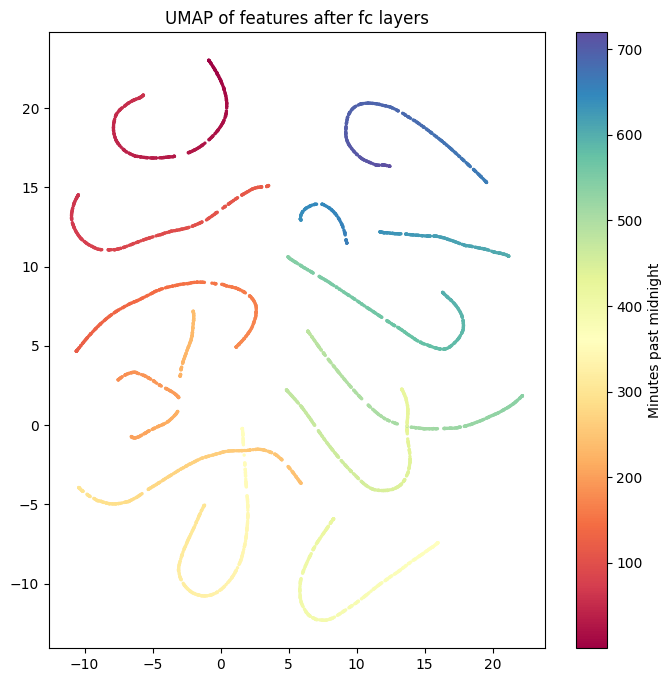

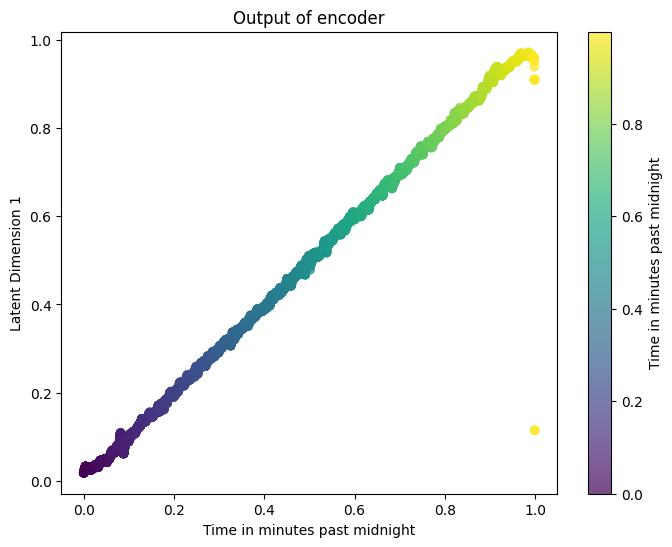

In [11]:
visualize_latent(type_, model, latent_dim=LATENT_DIM, dataloader=dataloader)